In [1]:
import gc
import os
from pathlib import Path
import random
import sys

from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import scipy as sp


import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.display import display, HTML

# --- plotly ---
from plotly import tools, subplots
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
import plotly.io as pio
pio.templates.default = "plotly_dark"

# --- models ---
from sklearn import preprocessing
from sklearn.model_selection import KFold
import lightgbm as lgb
import xgboost as xgb
import catboost as cb

# --- setup ---
pd.set_option('max_columns', 50)

In [2]:
import zarr

import l5kit
from l5kit.data import ChunkedDataset, LocalDataManager
from l5kit.dataset import EgoDataset, AgentDataset

from l5kit.rasterization import build_rasterizer
from l5kit.configs import load_config_data
from l5kit.visualization import draw_trajectory, TARGET_POINTS_COLOR
from l5kit.geometry import transform_points
from tqdm import tqdm
from collections import Counter
from l5kit.data import PERCEPTION_LABELS
from prettytable import PrettyTable

from matplotlib import animation, rc
from IPython.display import HTML

rc('animation', html='jshtml')
print("l5kit version:", l5kit.__version__)

l5kit version: 1.1.0


In [3]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error

In [4]:
import time
from datetime import datetime

In [5]:
os.environ["L5KIT_DATA_FOLDER"] = "/kaggle/input/lyft-motion-prediction-autonomous-vehicles"

In [6]:
dm = LocalDataManager()
dataset_path = dm.require('scenes/sample.zarr')
zarr_dataset = ChunkedDataset(dataset_path)
zarr_dataset.open()
print(zarr_dataset)

+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
| Num Scenes | Num Frames | Num Agents | Num TR lights | Total Time (hr) | Avg Frames per Scene | Avg Agents per Frame | Avg Scene Time (sec) | Avg Frame frequency |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
|    100     |   24838    |  1893736   |     316008    |       0.69      |        248.38        |        76.24         |        24.83         |        10.00        |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+


In [7]:
print(zarr_dataset.agents)
print(zarr_dataset.agents.shape)
n = zarr_dataset.agents.shape

<zarr.core.Array '/agents' (1893736,) [('centroid', '<f8', (2,)), ('extent', '<f4', (3,)), ('yaw', '<f4'), ('velocity', '<f4', (2,)), ('track_id', '<u8'), ('label_probabilities', '<f4', (17,))] read-only>
(1893736,)


In [8]:
# helper to convert a timedelta to a string (dropping milliseconds)
def deltaToString(delta):
    timeObj = time.gmtime(delta.total_seconds())
    return time.strftime('%H:%M:%S', timeObj)

class ProgressBar:
    
    # constructor
    #   maxIterations: maximum number of iterations
    def __init__(self, maxIterations):
        self.maxIterations = maxIterations
        self.granularity = 100 # 1 whole percent
    
    # start the timer
    def start(self):
        self.start = datetime.now()
    
    # check the progress of the current iteration
    #   # currentIteration: the current iteration we are on
    def check(self, currentIteration, chunked=False):
        if currentIteration % round(self.maxIterations / self.granularity) == 0 or chunked:
            
            percentage = round(currentIteration / (self.maxIterations - self.maxIterations / self.granularity) * 100)
            
            current = datetime.now()
            
            # time calculations
            timeElapsed = (current - self.start)
            timePerStep = timeElapsed / (currentIteration + 1)
            totalEstimatedTime = timePerStep * self.maxIterations
            timeRemaining = totalEstimatedTime - timeElapsed
            
            # string formatting
            percentageStr = "{:>3}%  ".format(percentage)
            remainingStr = "Remaining: {}  ".format(deltaToString(timeRemaining))
            elapsedStr = "Elapsed: {}  ".format(deltaToString(timeElapsed))
            totalStr = "Total: {}\r".format(deltaToString(totalEstimatedTime))
            
            print(percentageStr + remainingStr + elapsedStr + totalStr, end="")

    def end(self):
        print()

In [9]:
def getAgentsChunked(dataset, subsetPercent=1, chunks=10):

    datasetLength = round(len(dataset) * subsetPercent)
    chunkSize = round(datasetLength / chunks)
    
    pb = ProgressBar(datasetLength)
    pb.start()

    agents = []
    for i in range(0, datasetLength, chunkSize):

        agentsSubset = dataset[i:i+chunkSize]
        for j in range(0,len(agentsSubset)):

            agent = agentsSubset[j]
            track_id = agent[4]

            if track_id >= len(agents):
                agents.append([])

            data = []
            centroid = agent[0]
            yaw = agent[2]
            velocity = agent[3]
            data.append(centroid[0])
            data.append(centroid[1])
            data.append(yaw)
            data.append(velocity[0])
            data.append(velocity[1])
            agents[int(track_id)-1].append(data)
        pb.check(i, True)

    return agents

In [10]:
print(zarr_dataset.agents, "\n")
print(type(zarr_dataset.agents[0][0][0]))
print(type(zarr_dataset.agents[0][0]))
print(type(zarr_dataset.agents[0]))
print(type(zarr_dataset.agents))
agents = []
print(type(agents))

<zarr.core.Array '/agents' (1893736,) [('centroid', '<f8', (2,)), ('extent', '<f4', (3,)), ('yaw', '<f4'), ('velocity', '<f4', (2,)), ('track_id', '<u8'), ('label_probabilities', '<f4', (17,))] read-only> 

<class 'numpy.float64'>
<class 'numpy.ndarray'>
<class 'numpy.void'>
<class 'zarr.core.Array'>
<class 'list'>


In [11]:
subsetPercent = 1 #1*10**-2
print(subsetPercent)
agents = getAgentsChunked(zarr_dataset.agents, subsetPercent, 100)

1


In [12]:
def plotAgents(agents):
    r = lambda: random.randint(0,255)
    pb = ProgressBar(len(agents))
    pb.start()
    for i in range(0, len(agents)):
        agent = agents[i]
        centroid_x = []
        centroid_y = []
        for centroid in agent:
            centroid_x.append(centroid[0])
            centroid_y.append(centroid[1])
        plt.plot(centroid_x, centroid_y, 'o', color='#%02X%02X%02X' % (r(),r(),r()))
        pb.check(i)

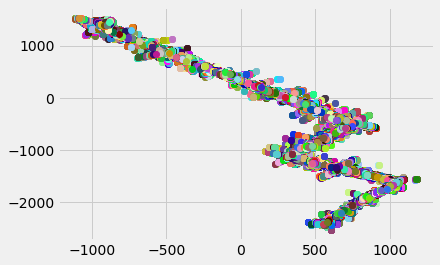

In [13]:
plotAgents(agents)

In [14]:
def normalizeAgents(agents):
    dataForNormalization = []
    pb = ProgressBar(len(agents))
    pb.start()
    for agent in agents:
        pb.check(0, True)
        for data in agent:
            for i in range(0, len(data)):
                feature = data[i]
                if i >= len(dataForNormalization):
                    dataForNormalization.append([])
                dataForNormalization[i].append(feature)
        
    
    first = True
    normalizedAgents = []
    pb = ProgressBar(len(dataForNormalization) * len(agents))
    pb.start()
    for i in range(0, len(dataForNormalization)):
        pb.end()
        data = dataForNormalization[i]
        mean = np.mean(data)
        std = np.std(data)
        print("max[{}]".format(i),np.max(data))
        print("min[{}]".format(i),np.min(data))
        print("mean[{}]".format(i),mean)
        print("std[{}]".format(i),std, "\n")
        
        for j in range(0, len(agents)):
            pb.check(i * j)
            if j >= len(normalizedAgents):
                normalizedAgents.append([])
                
            agent = agents[j]
            normalizedAgent = normalizedAgents[j]
            
            for k in range(0, len(agent)):
                if k >= len(normalizedAgent):
                    normalizedAgent.append([])
                data = agent[k]
                normalizedData = normalizedAgent[k]
                
                feature = data[i]
                normalizedFeature = (feature - mean) / std
                if i == 0 and first:
                    print(feature)
                    print(normalizedFeature)
                    first = False
                
                if i >= len(normalizedData):
                    normalizedData.append(0)
                normalizedData[i] = normalizedFeature
    return normalizedAgents

In [15]:
import copy

In [16]:
normalizedAgents = normalizeAgents(agents)

  0%  Remaining: 06:45:16  Elapsed: 00:00:09  Total: 06:45:26
max[0] 1179.1077880859375
min[0] -1111.6240234375
mean[0] 336.969584755944
std[0] 538.2572525153931 

665.0342407226562
0.6094941673959706
  0%  Remaining: 21:39:06  Elapsed: 00:00:12  Total: 21:39:19
max[1] 1538.580078125
min[1] -2527.596923828125
mean[1] -510.9562909092913
std[1] 976.0786362953986 

 20%  Remaining: 00:01:16  Elapsed: 00:00:18  Total: 00:01:35
max[2] 3.1415925
min[2] -3.1415882
mean[2] 0.597898
std[2] 1.1705885 

 40%  Remaining: 00:00:37  Elapsed: 00:00:24  Total: 00:01:02
max[3] 24.13901
min[3] -30.488567
mean[3] -0.0077168085
std[3] 2.2349012 

 60%  Remaining: 00:00:20  Elapsed: 00:00:30  Total: 00:00:50
max[4] 27.416363
min[4] -25.589865
mean[4] 0.012839541
std[4] 2.4340515 



In [17]:
print(len(agents))
print(len(normalizedAgents),"\n")

print(agents[0][0][0])
print(normalizedAgents[0][0][0],"\n")

2548
2548 

665.0342407226562
0.6094941673959706 



In [18]:
def printAgentsInfo(agents, limit):
    print("len(agents)", len(agents), "\n")

    agentCentroidLengths = []
    agentsOverLimit = []
    for agent in agents:
        agentCentroidLengths.append(len(agent))
        if len(agent) > limit:
            agentsOverLimit.append(agent)

    print("len(agentCentroidLengths)",len(agentCentroidLengths), "\n")

    print("max",np.max(agentCentroidLengths))
    print("min",np.min(agentCentroidLengths))
    print("mean",np.mean(agentCentroidLengths))
    print("std",np.std(agentCentroidLengths), "\n")

    print("agents with {}+ history".format(limit),len(agentsOverLimit))
    return agentsOverLimit

In [19]:
limit = 10
agentsOverLimit = printAgentsInfo(normalizedAgents, limit)

len(agents) 2548 

len(agentCentroidLengths) 2548 

max 14922
min 0
mean 743.2244897959183
std 942.0993728127904 

agents with 10+ history 2269


In [20]:
def getTrainingSets(agents, limit):
    allTrainingSets = []
    totalNumberOfTrainingSets = 0
    
    pb = ProgressBar(len(agentsOverLimit))
    pb.start()
    for i in range(0, len(agentsOverLimit)):
        agent = agentsOverLimit[i]
        agentTrainingSets = []
        for i in range(limit, len(agent)-1):
            agentTrainingSet = []

            start = i - limit
            end = i
            output = i + 1

            agentTrainingSet.append(agent[start:end])
            agentTrainingSet.append(agent[output])
            agentTrainingSets.append(agentTrainingSet)

            totalNumberOfTrainingSets = totalNumberOfTrainingSets + 1

        allTrainingSets.append(agentTrainingSets)
        pb.check(i)

    print("len(allTrainingSets)", len(allTrainingSets))
    print("len(allTrainingSets[0])",len(allTrainingSets[0]), "\n")

    print("len(agentsOverLimit)",len(agentsOverLimit))
    print("len(agentsOverLimit[0]) - limit - 1",len(agentsOverLimit[0]) - limit - 1, "\n")

    print("totalNumberOfTrainingSets",totalNumberOfTrainingSets)
    return allTrainingSets

In [21]:
allTrainingSets = getTrainingSets(agentsOverLimit, limit)

len(allTrainingSets) 2269
len(allTrainingSets[0]) 14911 

len(agentsOverLimit) 2269
len(agentsOverLimit[0]) - limit - 1 14911 

totalNumberOfTrainingSets 1867440


In [22]:
def flattenTrainingSets(allTrainingSets):
    allTrainingSetsFlattened_X = []
    allTrainingSetsFlattened_Y = []
    for allTrainingSet in allTrainingSets:
        for trainingSet in allTrainingSet:
            allTrainingSetsFlattened_X.append(trainingSet[0])
            allTrainingSetsFlattened_Y.append(trainingSet[1])
    print("len(allTrainingSetsFlattened_X)", len(allTrainingSetsFlattened_X))
    return allTrainingSetsFlattened_X, allTrainingSetsFlattened_Y

In [23]:
allTrainingSetsFlattened_X, allTrainingSetsFlattened_Y = flattenTrainingSets(allTrainingSets)

len(allTrainingSetsFlattened_X) 1867440


In [24]:
def reshapeFlattenedTrainingSets(allTrainingSetsFlattened_X, allTrainingSetsFlattened_Y):
    length = len(allTrainingSetsFlattened_X)
    depth = len(allTrainingSetsFlattened_X[0])
    channels = len(allTrainingSetsFlattened_X[0][0])

    print("length", length)
    print("depth", depth)
    print("channels",channels)
    print("length*depth*channels",length*depth*channels)

    allTrainingSetsFlattened_Input = np.reshape(allTrainingSetsFlattened_X, (length,depth,channels))
    allTrainingSetsFlattened_Output = np.reshape(allTrainingSetsFlattened_Y, (length,1,channels))

    print(allTrainingSetsFlattened_Input.shape[1])
    print(allTrainingSetsFlattened_Input.shape[2])
    
    return allTrainingSetsFlattened_Input, allTrainingSetsFlattened_Output

In [25]:
allTrainingSetsFlattened_Input = allTrainingSetsFlattened_X
allTrainingSetsFlattened_Output = allTrainingSetsFlattened_Y

In [26]:
allTrainingSetsFlattened_Input, allTrainingSetsFlattened_Output = reshapeFlattenedTrainingSets(allTrainingSetsFlattened_X, allTrainingSetsFlattened_Y)

length 1867440
depth 10
channels 5
length*depth*channels 93372000
10
5


In [27]:
# The LSTM architecture
regressor = Sequential()
# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(allTrainingSetsFlattened_Input.shape[1],allTrainingSetsFlattened_Input.shape[2])))
regressor.add(Dropout(0.2))
# Second LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Third LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Fourth LSTM layer
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.2))
# The output layer
regressor.add(Dense(units=allTrainingSetsFlattened_Input.shape[2]))

# Compiling the RNN
regressor.compile(optimizer='rmsprop',loss='mean_squared_error')

In [28]:
from tensorflow import keras

In [29]:
# Fitting to the training set

class CustomCallback(keras.callbacks.Callback):
    
    def __init__(self):
        self.epoch = 0
        
    def on_epoch_end(self, epoch, logs=None):
        keys = list(logs.keys())
        print("Epoch: {}             loss: {}\n".format(self.epoch, logs['loss']), end="")
        self.epoch = epoch

    def on_train_batch_end(self, batch, logs=None):
        keys = list(logs.keys())
        if batch % 100 == 0:
            print("Epoch: {} batchs: {}% loss: {}\r".format(self.epoch, round(batch / self.params['steps'] * 100), logs['loss']), end="")

regressor.fit(allTrainingSetsFlattened_Input,allTrainingSetsFlattened_Output,epochs=2,batch_size=128,verbose=0,callbacks=[CustomCallback()])

Epoch: 0             loss: 1.003911018371582
Epoch: 0             loss: 1.003881812095642


In [30]:
dataset_path_test = dm.require('scenes/test.zarr')
zarr_dataset_test = ChunkedDataset(dataset_path_test)
zarr_dataset_test.open()
print(zarr_dataset_test)

+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
| Num Scenes | Num Frames | Num Agents | Num TR lights | Total Time (hr) | Avg Frames per Scene | Avg Agents per Frame | Avg Scene Time (sec) | Avg Frame frequency |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
|   11314    |  1131400   |  88594921  |    7854144    |      31.43      |        100.00        |        78.31         |        10.00         |        10.00        |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+


In [31]:
print(len(zarr_dataset_test.agents))

88594921


In [32]:
subsetPercent = 1*10**-3
print(subsetPercent)
agentsTest = getAgentsChunked(zarr_dataset_test.agents, subsetPercent, 1000)

0.001


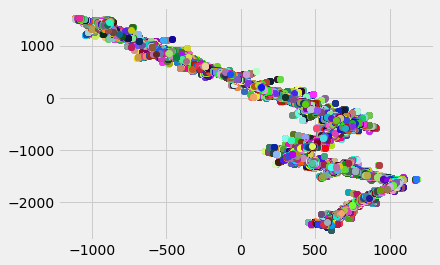

In [33]:
plotAgents(agents)

In [34]:
normalizedAgentsTest = normalizeAgents(agentsTest)

  0%  Remaining: 00:18:57  Elapsed: 00:00:01  Total: 00:18:58
max[0] 1176.3289794921875
min[0] 228.365234375
mean[0] 642.6905530002873
std[0] 187.8624770611012 

532.249755859375
-0.5878810865726638
  0%  Remaining: 01:38:23  Elapsed: 00:00:01  Total: 01:38:25
max[1] -787.3958129882812
min[1] -2457.771728515625
mean[1] -1604.0917417434066
std[1] 448.5577253894946 

 20%  Remaining: 00:00:06  Elapsed: 00:00:01  Total: 00:00:08
max[2] 3.1413598
min[2] -3.14054
mean[2] 0.6456462
std[2] 1.1209098 

 40%  Remaining: 00:00:03  Elapsed: 00:00:02  Total: 00:00:05
max[3] 13.556842
min[3] -14.46901
mean[3] -0.030624595
std[3] 1.9196839 

 60%  Remaining: 00:00:01  Elapsed: 00:00:02  Total: 00:00:03
max[4] 16.831251
min[4] -19.91049
mean[4] 0.21769048
std[4] 2.4886796 



In [35]:
agentsTestOverLimit = printAgentsInfo(normalizedAgentsTest, limit)

len(agents) 849 

len(agentCentroidLengths) 849 

max 1072
min 0
mean 104.40989399293287
std 128.88514146361 

agents with 10+ history 741


In [36]:
allTestingSets = getTrainingSets(agentsTestOverLimit, limit)

len(allTrainingSets) 2269
len(allTrainingSets[0]) 14911 

len(agentsOverLimit) 2269
len(agentsOverLimit[0]) - limit - 1 14911 

totalNumberOfTrainingSets 1867440


In [37]:
allTestingSetsFlattened_X, allTestingSetsFlattened_Y = flattenTrainingSets(allTestingSets)

len(allTrainingSetsFlattened_X) 1867440


In [38]:
allTestingSetsFlattened_Input, allTestingSetsFlattened_Output = reshapeFlattenedTrainingSets(allTestingSetsFlattened_X, allTestingSetsFlattened_Y)

length 1867440
depth 10
channels 5
length*depth*channels 93372000
10
5


In [39]:
max = len(allTestingSetsFlattened_Input)
print(max)
chunkSize = 1000
pb = ProgressBar(max)
pb.start()
predictedTestAgentCentroid = np.empty((1,5))
for i in range(0, max-chunkSize, chunkSize):#len(zarr_dataset.agents)):
    newPredictions = regressor.predict(allTestingSetsFlattened_Input[i:i+chunkSize])
    predictedTestAgentCentroid = np.concatenate((predictedTestAgentCentroid, newPredictions))
    pb.check(i, True)


1867440


In [40]:
print(len(predictedTestAgentCentroid))
predictedTestAgentCentroid = predictedTestAgentCentroid[1:len(predictedTestAgentCentroid)]
print(len(predictedTestAgentCentroid))

1867001
1867000


In [41]:
randomSamples = 10
for i in range(0, len(predictedTestAgentCentroid), round(len(predictedTestAgentCentroid) / randomSamples)):
    testSet = allTestingSetsFlattened_Input[i]
    print(testSet[0][0])
    print(predictedTestAgentCentroid[i][0],"\n")

0.6094941673959706
0.0025729008484631777 

-2.387022767803382
-0.014377855695784092 

0.1819302038425144
-0.000785033218562603 

0.41561533164328257
-0.0020648431964218616 

-0.8210105057457325
-0.006062093190848827 

0.5603058805225293
-8.311890996992588e-05 

1.037024452924056
0.00293122255243361 

0.5523047981313972
0.0025851347018033266 

0.7906936234756256
0.0008798616472631693 

0.6692735695814034
-0.0003164258087053895 

